In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile, DenseNet169
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [10]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [11]:
normal_train = np.array(Dataset_loader('/content/drive/MyDrive/Covid-19/train/normal',224))
covid19_train = np.array(Dataset_loader('/content/drive/MyDrive/Covid-19/train/covid-19',224))
normal_test = np.array(Dataset_loader('/content/drive/MyDrive/Covid-19/test/normal',224))
covid19_test = np.array(Dataset_loader('/content/drive/MyDrive/Covid-19/test/covid-19',224))

100%|██████████| 234/234 [00:15<00:00, 15.24it/s]


In [ ]:
print(len(normal_train))
print(len(covid19_train))
print(len(normal_test))
print(len(covid19_test))

1260
821
90
86


In [12]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
covid19_train_label = np.ones(len(covid19_train))
normal_test_label = np.zeros(len(normal_test))
covid19_test_label = np.ones(len(covid19_test))

In [13]:
print(len(covid19_train_label))
print(len(covid19_test_label))
print(len(normal_test_label))

544
233
330


In [14]:
# Merge data
X_train = np.concatenate((normal_train, covid19_train), axis = 0)
Y_train = np.concatenate((normal_train_label, covid19_train_label), axis = 0)
X_test = np.concatenate((normal_test, covid19_test), axis = 0)
Y_test = np.concatenate((normal_test_label, covid19_test_label), axis = 0)


In [15]:
print(len(X_train))
print(len(X_test))
print(len(Y_test))

1314
563
563


In [16]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [18]:
from keras.utils import to_categorical


In [19]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [21]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.3,
    random_state=11
)

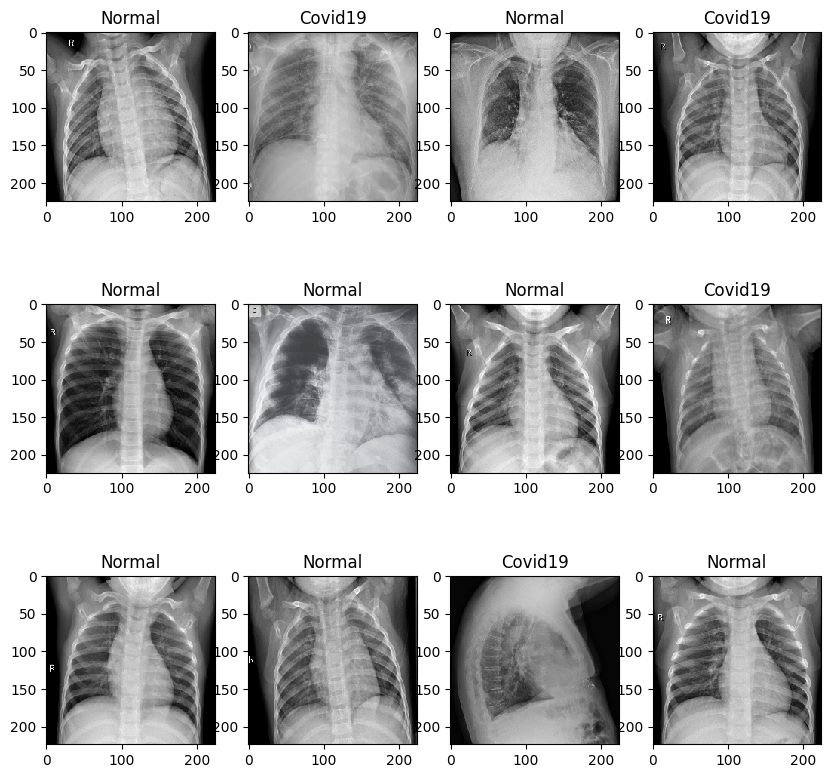

In [22]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Covid19')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [23]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [24]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

dennet  = DenseNet169(include_top=False, input_shape=input_shape)(inputs)
resnet  = ResNet50(include_top=False, input_shape=input_shape)(inputs)
vgg     = VGG19(include_top=False, input_shape=input_shape)(inputs)

80134624/80134624 [==============================] - 0s 0us/step


In [26]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(resnet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                            

In [27]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/Covid-19.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [36]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-36-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
29/28 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9293

28/28 [==============================] - 41s 1s/step - loss: 0.1650 - accuracy: 0.9293 - val_loss: 0.6399 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 2/40
29/28 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9086

28/28 [==============================] - 40s 1s/step - loss: 0.2293 - accuracy: 0.9086 - val_loss: 0.3044 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 3/40
29/28 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9325

28/28 [==============================] - 40s 1s/step - loss: 0.1839 - accuracy: 0.9325 - val_loss: 1.9103 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 4/40
29/28 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9217

28/28 [==============================] - 41s 1s/step - loss: 0.2074 - accuracy: 0.9217 - val_loss: 2.7335 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 5/40
29/28 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9064

28/28 [==============================] - 41s 1s/step - loss: 0.1999 - accuracy: 0.9064 - val_loss: 0.0953 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 6/40
29/28 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9217

28/28 [==============================] - 40s 1s/step - loss: 0.1902 - accuracy: 0.9217 - val_loss: 0.0436 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 7/40
29/28 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9260

28/28 [==============================] - 42s 1s/step - loss: 0.2127 - accuracy: 0.9260 - val_loss: 0.5835 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 8/40
29/28 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9227

28/28 [==============================] - 41s 1s/step - loss: 0.1942 - accuracy: 0.9227 - val_loss: 0.1515 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 9/40
29/28 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9227

28/28 [==============================] - 40s 1s/step - loss: 0.1828 - accuracy: 0.9227 - val_loss: 0.4958 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 10/40
29/28 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9358

28/28 [==============================] - 40s 1s/step - loss: 0.1605 - accuracy: 0.9358 - val_loss: 0.2300 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 11/40
29/28 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9380

28/28 [==============================] - 41s 1s/step - loss: 0.1736 - accuracy: 0.9380 - val_loss: 0.1941 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 12/40
29/28 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9402

28/28 [==============================] - 40s 1s/step - loss: 0.1532 - accuracy: 0.9402 - val_loss: 0.7040 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 13/40
29/28 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9260

28/28 [==============================] - 40s 1s/step - loss: 0.1873 - accuracy: 0.9260 - val_loss: 0.6596 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 14/40
29/28 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9358

28/28 [==============================] - 40s 1s/step - loss: 0.1671 - accuracy: 0.9358 - val_loss: 3.2944 - val_accuracy: 0.4025 - lr: 0.0010
Epoch 15/40
29/28 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9445

28/28 [==============================] - 39s 1s/step - loss: 0.1519 - accuracy: 0.9445 - val_loss: 0.0827 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 16/40
29/28 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9358

28/28 [==============================] - 39s 1s/step - loss: 0.1698 - accuracy: 0.9358 - val_loss: 0.3686 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 17/40
29/28 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9227

28/28 [==============================] - 39s 1s/step - loss: 0.1738 - accuracy: 0.9227 - val_loss: 0.4581 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 18/40
29/28 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.9347

28/28 [==============================] - 40s 1s/step - loss: 0.1722 - accuracy: 0.9347 - val_loss: 0.7040 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 19/40
29/28 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9314

28/28 [==============================] - 40s 1s/step - loss: 0.1766 - accuracy: 0.9314 - val_loss: 0.5362 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 20/40
29/28 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9336

28/28 [==============================] - 41s 1s/step - loss: 0.1821 - accuracy: 0.9336 - val_loss: 0.3907 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 21/40
29/28 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9325

28/28 [==============================] - 41s 1s/step - loss: 0.1871 - accuracy: 0.9325 - val_loss: 0.5109 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 22/40
29/28 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9271

28/28 [==============================] - 42s 1s/step - loss: 0.1799 - accuracy: 0.9271 - val_loss: 0.3336 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 23/40
29/28 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9489

28/28 [==============================] - 40s 1s/step - loss: 0.1468 - accuracy: 0.9489 - val_loss: 0.6944 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 24/40
29/28 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9227

28/28 [==============================] - 39s 1s/step - loss: 0.1999 - accuracy: 0.9227 - val_loss: 0.0984 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 25/40
29/28 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9336

28/28 [==============================] - 40s 1s/step - loss: 0.1756 - accuracy: 0.9336 - val_loss: 0.1440 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 26/40
29/28 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9271

28/28 [==============================] - 40s 1s/step - loss: 0.1734 - accuracy: 0.9271 - val_loss: 0.1267 - val_accuracy: 0.9646 - lr: 0.0010
Epoch 27/40
29/28 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9314

28/28 [==============================] - 39s 1s/step - loss: 0.1901 - accuracy: 0.9314 - val_loss: 9.2762 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 28/40
29/28 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9293

28/28 [==============================] - 40s 1s/step - loss: 0.1803 - accuracy: 0.9293 - val_loss: 12.8267 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 29/40
29/28 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9478

28/28 [==============================] - 39s 1s/step - loss: 0.1466 - accuracy: 0.9478 - val_loss: 0.6547 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 30/40
29/28 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9391

28/28 [==============================] - 40s 1s/step - loss: 0.1482 - accuracy: 0.9391 - val_loss: 0.2269 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 31/40
29/28 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9271

28/28 [==============================] - 40s 1s/step - loss: 0.1779 - accuracy: 0.9271 - val_loss: 8.5139 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 32/40
29/28 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9391

28/28 [==============================] - 39s 1s/step - loss: 0.1427 - accuracy: 0.9391 - val_loss: 0.9016 - val_accuracy: 0.8759 - lr: 0.0010
Epoch 33/40
29/28 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9249

28/28 [==============================] - 40s 1s/step - loss: 0.1545 - accuracy: 0.9249 - val_loss: 0.5223 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 34/40
29/28 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9347

28/28 [==============================] - 40s 1s/step - loss: 0.1529 - accuracy: 0.9347 - val_loss: 0.4518 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 35/40
29/28 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9293

28/28 [==============================] - 40s 1s/step - loss: 0.1654 - accuracy: 0.9293 - val_loss: 0.4593 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 36/40
29/28 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9587

28/28 [==============================] - 40s 1s/step - loss: 0.1348 - accuracy: 0.9587 - val_loss: 0.1497 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 37/40
29/28 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9412

28/28 [==============================] - 39s 1s/step - loss: 0.1445 - accuracy: 0.9412 - val_loss: 0.1846 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 38/40
29/28 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9314

28/28 [==============================] - 39s 1s/step - loss: 0.1660 - accuracy: 0.9314 - val_loss: 0.0588 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 39/40
29/28 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9314

28/28 [==============================] - 40s 1s/step - loss: 0.1769 - accuracy: 0.9314 - val_loss: 0.1450 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 40/40
29/28 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9304

28/28 [==============================] - 39s 1s/step - loss: 0.1690 - accuracy: 0.9304 - val_loss: 0.0930 - val_accuracy: 0.9595 - lr: 0.0010


In [37]:
Y_pred = model.predict(X_test)

18/18 [==============================] - 6s 338ms/step


Confusion matrix, without normalization
[[308  22]
 [  4 229]]


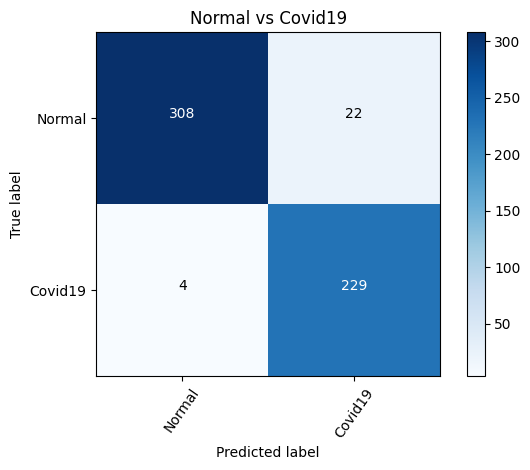

In [38]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Covid19']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Covid19')

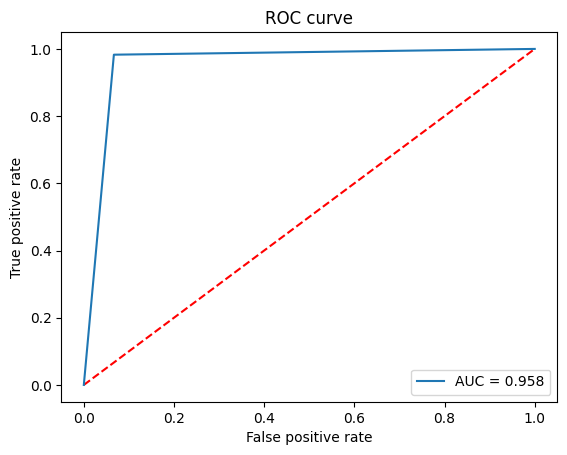

In [39]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

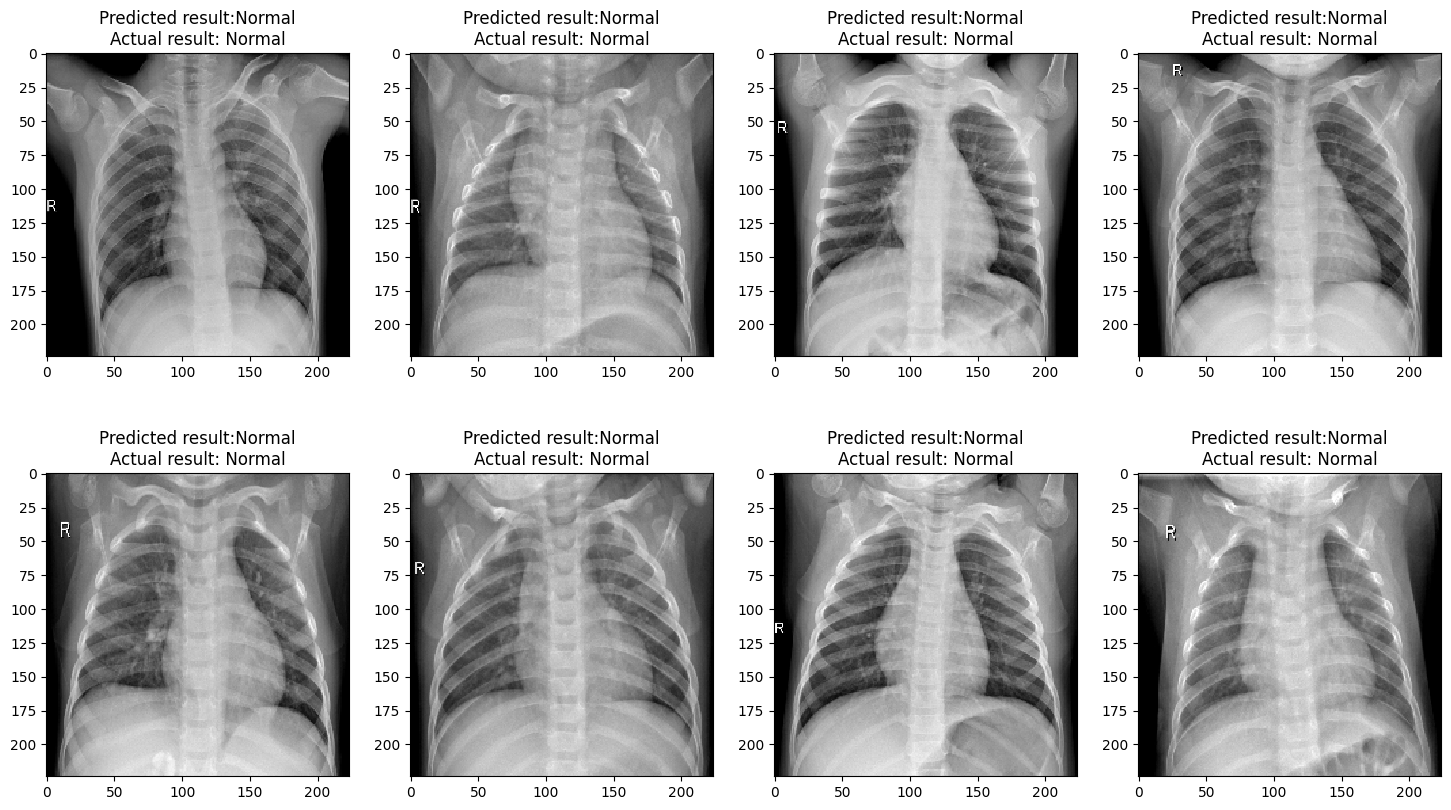

In [32]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Covid19"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

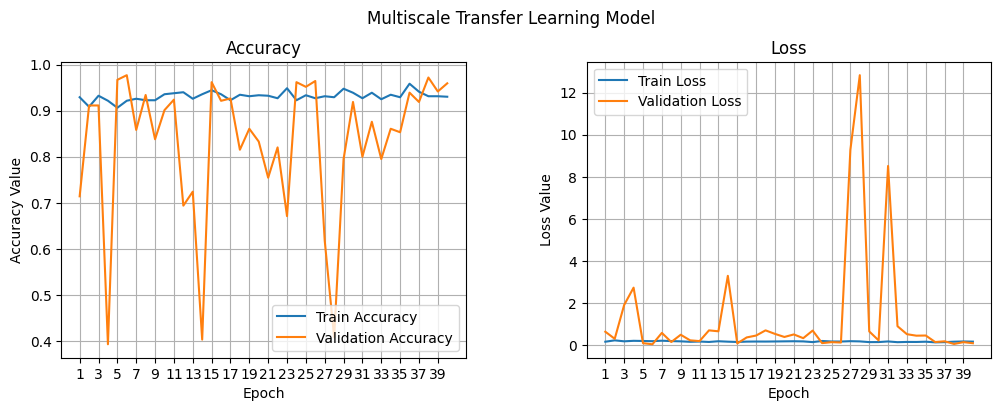

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [41]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

18/18 [==============================] - 6s 339ms/step


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Covid19']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       0.99      0.93      0.96       330
     Covid19       0.91      0.98      0.95       233

    accuracy                           0.95       563
   macro avg       0.95      0.96      0.95       563
weighted avg       0.96      0.95      0.95       563

